## FMI Weather station measurements

Measurements were done overnight between 24.-25.7.2020.

Espoo, Nuuksio, <15 km from the measurement location  
Espoo, Tapiola, <15 km from the measurement location  
https://www.ilmatieteenlaitos.fi/havaintojen-lataus

In [1]:
import pandas as pd
import numpy as np

In [2]:
files = [
    "FMI_DATA/FMI_weather_data_24_25_7_2020_Espoo_Nuuksio.csv",
    "FMI_DATA/FMI_weather_data_24_25_7_2020_Espoo_Tapiola.csv",
]

In [3]:
dataframes = []
for filepath in files:
    with open(filepath, "rb") as f:
        dataframe = pd.read_csv(f)
        dataframe["location"] = filepath.split(".")[0].split("_")[-1]
        dataframes.append(dataframe)

dataframe = pd.concat(dataframes, axis=0)

In [4]:
def to_datetime(df):
    df = df.rename(columns={
        "Vuosi" : "year", 
        "Kk" : "month", 
        "Pv" : "day", 
        "Klo" : "time"
    })
    df[["hour", "minutes"]] = df["time"].apply(lambda x: pd.Series(
        x.split(":"), index=["hour", "minutes"]
    ))
    datetime = pd.to_datetime(df[
        ["year", "month", "day", "hour", "minutes"]
    ])
    return datetime.dt.tz_localize("utc").dt.tz_convert("Europe/Helsinki")

In [5]:
dataframe["datetime"] = to_datetime(dataframe)

In [6]:
overnight_slicer = (
    dataframe.datetime > pd.Timestamp("2020-07-24 19:00", tz="Europe/Helsinki")) & (
    dataframe.datetime < pd.Timestamp("2020-07-25 13:00", tz="Europe/Helsinki")
)

In [7]:
dataframe_overnight = dataframe[overnight_slicer]

In [8]:
precipitation = dataframe_overnight.groupby("location")["Sateen intensiteetti (mm/h)"].apply(lambda x: (x/6).sum())

In [9]:
precipitation

location
Nuuksio    1.350000
Tapiola    4.066667
Name: Sateen intensiteetti (mm/h), dtype: float64

In [10]:
print("Precipitation")
for location, result in precipitation.iteritems():
    print(f"    {location}: {result:.2f} mm")

Precipitation
    Nuuksio: 1.35 mm
    Tapiola: 4.07 mm


In [11]:
precipitation.index.name = None
precipitation.name = "Precipitation overnight (mm)"

In [12]:
precipitation.to_csv("FMI_DATA/precipitation.csv", header=True)

# Measurement Data

Similar measurements are i.i.d which means that different measurements should not be paired.
Number of measurements between the differents objecs (blue, yellow or water, no-water) can differ,
but are the same in this example.

## Weights (in grams)

In [13]:
weight_bucket = pd.DataFrame.from_dict({
    "blue" : [127, 128, 128],
    "yellow" : [129, 129, 128],
})
weight_bucket_water = pd.DataFrame.from_dict({
    "blue" : [170, 169, 169],
    "yellow" : [168, 169, 168],
})

In [14]:
weight_bucket

,blue,yellow
0,127,129
1,128,129
2,128,128


In [15]:
weight_bucket_water

,blue,yellow
0,170,168
1,169,169
2,169,168


# Lengths (in centimeters)

## Geometry

In [16]:
from helper_functions import create_geometry

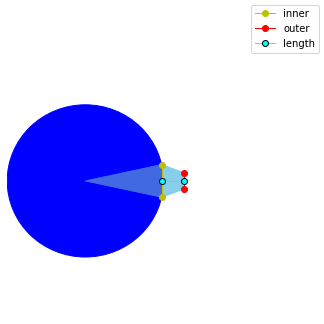

In [17]:
create_geometry()

In [18]:
# outer diameter
diameter_bucket = pd.DataFrame.from_dict({
    "blue" : np.array([14.8-1.0]),
    "yellow" : np.array([15.0-1.0]),
})

radius_bucket = diameter_bucket / 2

# inner wedge length (yellow dots)
wedge_bucket_inner = pd.DataFrame.from_dict({
    "blue" : np.array([6.0]),
    "yellow" : np.array([6.0])
})

# inner wedge length (red dots)
wedge_bucket_outer = pd.DataFrame.from_dict({
    "blue" : np.array([3.0]),
    "yellow" : np.array([3.0])
})

# inner wedge length (cyan dots)
wedge_bucket_lenght = pd.DataFrame.from_dict({
    "blue" : np.array([4.0]),
    "yellow" : np.array([4.0])
})

# External data

In [19]:
# temp 15degC
density_water = 999 # kg / m^3

In [20]:
import pickle

In [22]:
with open("DATA/measurement_data.pickle", "wb") as f:
    pickle.dump({
        "weight_bucket" : weight_bucket,
        "weight_bucket_water" : weight_bucket_water,
        "diameter" : diameter_bucket,
        "radius" : radius_bucket,
        "wedge_outer" : wedge_bucket_outer,
        "wedge_inner" : wedge_bucket_inner,
        "wedge_length" : wedge_bucket_lenght,
        "density_water" : density_water,
    }, file=f)